Usage: python finite_square_well.py [mass_kg] [well_width_m] [well_depth_eV]
Using default values for an electron in a well of width 1 nm and depth 10 eV.

Eigenenergies (eV):
  State 1: -9.702936 eV
  State 2: -8.815873 eV
  State 3: -7.352885 eV
  State 4: -5.345174 eV
  State 5: -2.867250 eV
  State 6: -0.200653 eV
  State 7: 1.229407 eV
  State 8: 1.767701 eV
  State 9: 3.435857 eV
  State 10: 5.277188 eV
(Higher states may be unbound if E > 0.)



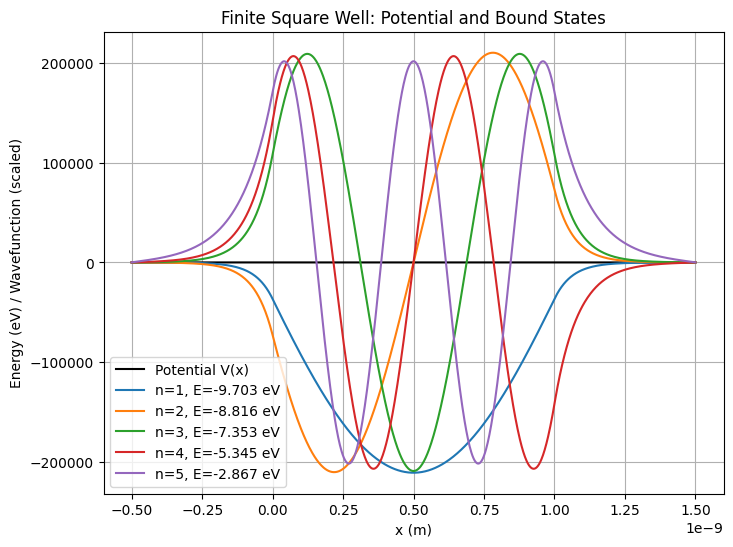

In [1]:
#!/usr/bin/env python3

import sys
import numpy as np
import matplotlib.pyplot as plt

def solve_finite_square_well(mass, L, well_depth_eV, N=500):
    """
    Solve the 1D finite square well problem using a finite-difference
    approximation of the time-independent Schrödinger equation:
        (-hbar^2 / 2m) d^2/dx^2 + V(x)) * psi(x) = E * psi(x)

    Parameters
    ----------
    mass : float
        Mass of the particle (e.g., electron mass in kg).
    L : float
        Width of the well (meters).
    well_depth_eV : float
        Depth of the well in eV (V0). Potential inside is -V0, outside is 0.
    N : int, optional
        Number of grid points (excluding boundaries) in the total domain.

    Returns
    -------
    energies_eV : ndarray
        Eigenvalues (energies) in eV, sorted in ascending order.
    wavefuncs : ndarray
        Array of shape (N, n_states) containing the eigenfunctions on the grid.
        wavefuncs[i, k] is the k-th eigenfunction at x[i].
    x : ndarray
        Coordinate array of length N (from x_min to x_max).
    Vx_eV : ndarray
        Potential array (in eV) evaluated on the same grid.
    """

    # Physical constants
    hbar = 1.054571817e-34  # J*s (reduced Planck's constant)
    eV_to_J = 1.602176634e-19  # 1 eV = 1.602176634e-19 J

    # Convert well depth from eV to Joules
    well_depth_J = well_depth_eV * eV_to_J

    # Choose a domain that extends beyond [0, L] so the wavefunction
    # can decay to ~0 at the boundaries.
    # For example, extend 0.5L on each side:
    x_min = -0.5 * L
    x_max =  1.5 * L

    # Create the spatial grid (N points total)
    x = np.linspace(x_min, x_max, N)
    dx = x[1] - x[0]

    # Construct the potential array (in Joules)
    #   V(x) = -well_depth_J for 0 <= x <= L, else 0
    Vx = np.zeros_like(x)
    for i in range(N):
        if 0.0 <= x[i] <= L:
            Vx[i] = -well_depth_J
        else:
            Vx[i] = 0.0

    # Construct the finite-difference Hamiltonian matrix
    # Kinetic energy operator: T = - (hbar^2 / 2m) d^2/dx^2
    # We'll build a tridiagonal matrix for the second derivative.
    main_diag = np.zeros(N)
    off_diag = np.ones(N-1)
    
    # Coefficient for second derivative
    coeff_kin = - (hbar**2) / (2.0 * mass * dx**2)
    
    # Diagonal elements:  -2 * coeff_kin + V(x_i)
    for i in range(N):
        main_diag[i] = -2.0 * coeff_kin + Vx[i]
    
    # Off-diagonal elements: +1 * coeff_kin
    # So the matrix is:
    # [ -2*coeff_kin+Vx[0],  coeff_kin,            0,         ... ]
    # [ coeff_kin,          -2*coeff_kin+Vx[1],    coeff_kin, ... ]
    # [ 0,                  coeff_kin,            -2*coeff_kin+Vx[2], ... ]
    # ...
    H = (np.diag(main_diag) +
         np.diag(off_diag * coeff_kin, k=1) +
         np.diag(off_diag * coeff_kin, k=-1))

    # Solve the eigenvalue problem H psi = E psi
    # eigenvals in Joules, eigenvecs in same dimension as x
    eigenvals, eigenvecs = np.linalg.eigh(H)

    # Sort eigenvalues (ascending) and reorder eigenvectors accordingly
    idx = np.argsort(eigenvals)
    eigenvals = eigenvals[idx]
    eigenvecs = eigenvecs[:, idx]

    # Convert eigenvalues to eV
    energies_eV = eigenvals / eV_to_J

    # Normalize eigenfunctions so that \int |psi|^2 dx = 1
    # using discrete sum( |psi_i|^2 )*dx ~ 1
    for i in range(eigenvecs.shape[1]):
        norm = np.sqrt(np.sum(np.abs(eigenvecs[:, i])**2) * dx)
        eigenvecs[:, i] /= norm

    # Convert potential to eV for plotting
    Vx_eV = Vx / eV_to_J

    return energies_eV, eigenvecs, x, Vx_eV


def main():
    """
    Main function to:
      1) Read mass (kg), well width (m), and well depth (eV) from command line.
      2) Solve the finite square well for bound states.
      3) Print energies (in eV).
      4) Plot the potential and first few bound-state wavefunctions.
    """
    # Physical constants
    # eV_to_J = 1.602176634e-19  # Not strictly needed here

    # Read inputs or set defaults
    if len(sys.argv) == 4:
        mass = float(sys.argv[1])           # in kg
        L = float(sys.argv[2])             # in meters
        well_depth_eV = float(sys.argv[3]) # in eV
    else:
        print("Usage: python finite_square_well.py [mass_kg] [well_width_m] [well_depth_eV]")
        print("Using default values for an electron in a well of width 1 nm and depth 10 eV.")
        mass = 9.10938356e-31   # electron mass (kg)
        L = 1.0e-9              # 1 nm
        well_depth_eV = 10.0    # 10 eV

    # Number of grid points (adjust for accuracy)
    N = 1000

    # Solve
    energies_eV, wavefuncs, x, Vx_eV = solve_finite_square_well(mass, L, well_depth_eV, N=N)

    # Print first few eigenenergies (the negative ones are bound states)
    # Because we set V=0 outside and V=-V0 inside, bound states have E < 0 eV.
    print("\nEigenenergies (eV):")
    for i, E in enumerate(energies_eV[:10], start=1):
        print(f"  State {i}: {E:.6f} eV")
    print("(Higher states may be unbound if E > 0.)\n")

    # Plot the potential and the first few wavefunctions (those with E<0)
    plt.figure(figsize=(8,6))

    # Plot the potential in eV vs x
    plt.plot(x, Vx_eV, 'k-', label="Potential V(x)")

    # Find all bound states (E<0)
    bound_indices = np.where(energies_eV < 0)[0]

    # How many bound states to plot?
    n_to_plot = min(len(bound_indices), 5)

    # Plot wavefunctions for the first few bound states
    for i in range(n_to_plot):
        idx_state = bound_indices[i]
        E = energies_eV[idx_state]
        psi = wavefuncs[:, idx_state]

        # Scale wavefunction for visibility
        # We'll shift wavefunction so that min(psi) is near E
        # or simply shift by E and scale amplitude.
        scale = 0.5 * abs(np.min(Vx_eV))  # a scale factor for visibility
        y_psi = psi * scale + E  # shift wavefunction by its energy

        plt.plot(x, y_psi, label=f"n={i+1}, E={E:.3f} eV")

    plt.title("Finite Square Well: Potential and Bound States")
    plt.xlabel("x (m)")
    plt.ylabel("Energy (eV) / Wavefunction (scaled)")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
